In [20]:
import torch
from bart import bart
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tqdm import tqdm_notebook
from tqdm import tqdm
from data import transforms as T
# from train_vs_sens import create_data_loaders, build_model
from pathlib import Path
from collections import namedtuple
from torch import nn
import math
from models.models import SSIM 
ssim_loss = SSIM().cuda()
from train_var12_finetune import create_data_loaders , build_model , load_model
from models.models import architecture

In [9]:
args = {'center_fractions':[0.08],'accelerations':[4],'challenge':'singlecoil',
       'data_path':Path('/media/student1/RemovableVolume/calgary'),
        
       'resolution':170,
       'sample_rate':0.01,
       'batch_size':1,
        'device':'cuda',
        'data_parallel':False,
        'num_chans':32,
        'num_pools':4,
        'drop_prob':0,
        'acceleration':5,
        'num_train':155,
        'dropout':0,
        'sample_rate':0.01,
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())
args = namedtuple('args',args.keys())(*args.values())

In [10]:
train_loader, dev_loader,display_loader = create_data_loaders(args,args.data_path)
len(train_loader)

73

In [12]:
for iter,data in enumerate(train_loader):
    ksp_us,img_us,img_us_np,img_gt_np,sens,mask,maxi,fname = data
    break
ksp_us = ksp_us.to(args.device)
sens = sens.to(args.device)
mask = mask.to(args.device)
img_us = img_us.to(args.device)
img_gt_np = img_gt_np.unsqueeze(0).to(args.device).float()
img_us_np = img_us_np.unsqueeze(0).to(args.device).float()

torch.Size([1, 12, 218, 170, 2]) torch.Size([1, 1, 218, 170]) torch.Size([1, 12, 218, 170, 2]) ('/media/student1/RemovableVolume/calgary/Train/e14427s3_P76288.7.129.h5',)
Channel-wise US image


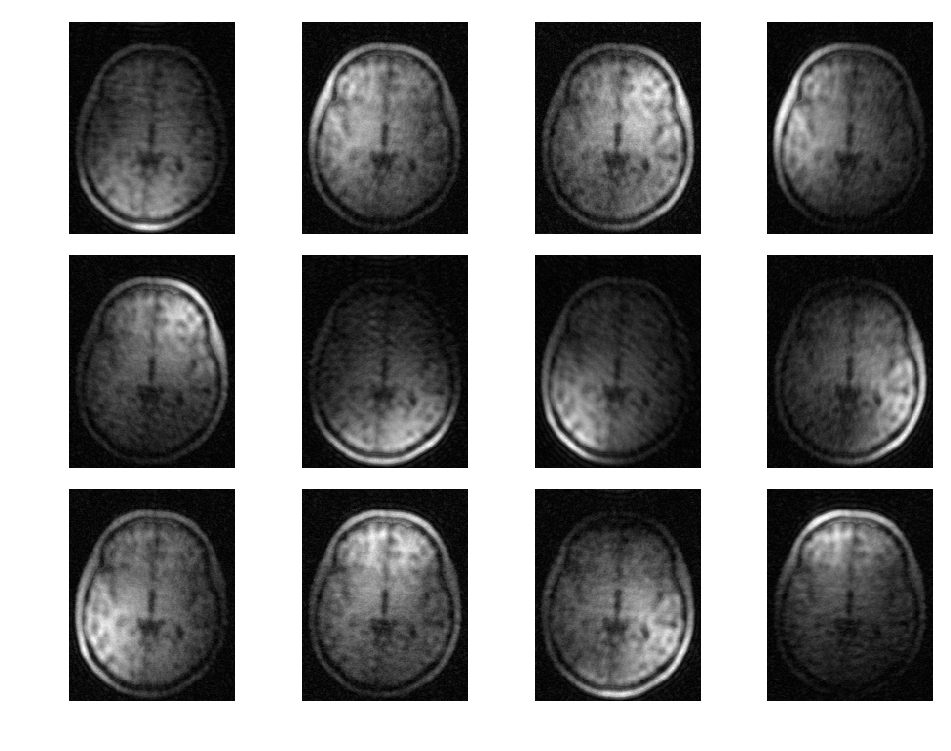

Channel-wise sensitivity maps


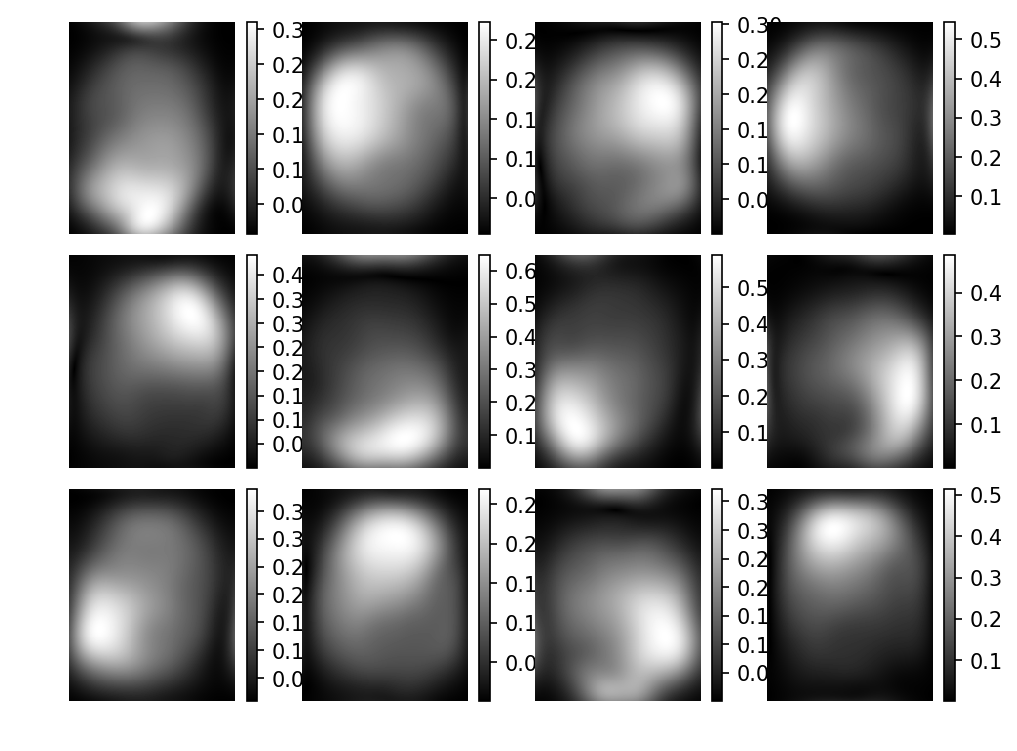

In [13]:
print(img_us.shape , img_gt_np.shape , sens.shape , fname)
print("Channel-wise US image") 
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(torch.sqrt(img_us[0,ii,:,:,0].detach().cpu()**2 + img_us[0,ii,:,:,1].detach().cpu()**2),cmap='gray')
#     plt.imshow(np.abs(sample_rec_train[:,:,ii]),cmap = "gray")
    plt.axis("off")
plt.show()

print("Channel-wise sensitivity maps") 
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(torch.sqrt(sens[0,ii,:,:,0].detach().cpu()**2 + sens[0,ii,:,:,1].detach().cpu()**2),cmap='gray')
#     plt.imshow(np.abs(sample_rec_train[:,:,ii]),cmap = "gray")
    plt.axis("off")
    plt.colorbar()
plt.show()

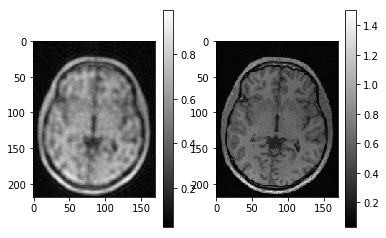

In [16]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
plt.imshow(img_us_np[0,0,:,:].detach().cpu(),cmap='gray')
plt.colorbar()
plt.subplot(gs1[1])
plt.imshow(img_gt_np[0,0,:,:].detach().cpu(),cmap='gray')
plt.colorbar()

In [21]:
pretext_model = '/media/student1/NewVolume/MR_Reconstruction/experiments/midl/varnet/12-channels/pretext/acc_5x/best_model.pt'
model1  = build_model(args)
_, model0,_ = load_model(pretext_model)

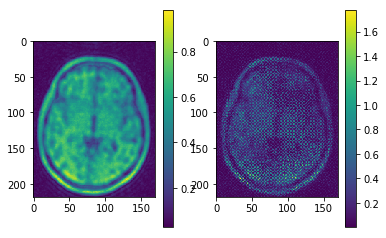

In [25]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
out,out_stack,sens= model0(img_us,ksp_us,mask)
plt.imshow(out[0,0,:,:].detach().cpu().numpy())
plt.colorbar()

plt.subplot(gs1[1])
out1,out_stack1,sens1= model1(img_us,ksp_us,mask)
plt.imshow(out1[0,0,:,:].detach().cpu().numpy())
plt.colorbar()

In [29]:
img_us_sens = T.combine_all_coils(img_us.squeeze(0),sens.squeeze(0)).unsqueeze(0)
img_us_sens.shape

torch.Size([1, 218, 170, 2])

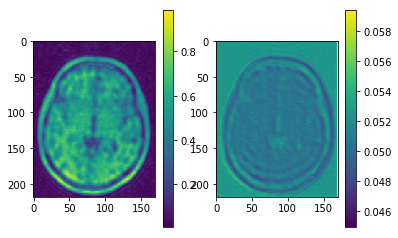

In [35]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
out = model0.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out[0,:,:,0].detach().cpu().numpy()**2 + out[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

plt.subplot(gs1[1])
out1 = model1.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out1[0,:,:,0].detach().cpu().numpy()**2 + out1[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

In [37]:
# changing the weights of model0
model0.model_vs.conv_blocks[0] = model1.model_vs.conv_blocks[0]

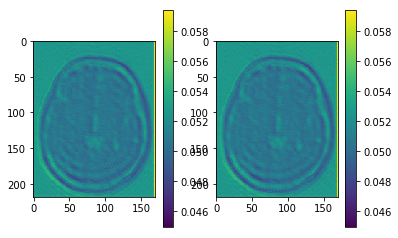

In [38]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
out = model0.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out[0,:,:,0].detach().cpu().numpy()**2 + out[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

plt.subplot(gs1[1])
out1 = model1.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out1[0,:,:,0].detach().cpu().numpy()**2 + out1[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

In [50]:
bck = 2
for i in range(-bck,0):
    print("i=",i)
    

i= -2
i= -1
